In [6]:
import sys
import os

# Get the current working directory, then step back
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Insert the parent directory into sys.path
sys.path.insert(0, parent_dir)


In [7]:
parent_dir

'c:\\Users\\DivyaPrakash\\Documents\\Divya\\Stock_Market_prediction\\StockAnalysis'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta
from src import stock_info as si
import joblib


In [ ]:
#plot historical data.
start_date = datetime(2010, 1, 1) 
end_date = datetime.today().date()
ticker = "NIFTY50.NS"

historical_data = si.get_historical_data(start_date=start_date, end_date=end_date, ticker=ticker)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NIFTY50.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 00:00:00 -> 2025-04-15)')


data shape check:(0, 6)


In [ ]:
historical_data.head()

,Close_SBIN.NS,High_SBIN.NS,Low_SBIN.NS,Open_SBIN.NS,Volume_SBIN.NS
Date,,,,,
2010-01-04,192.488815,193.228127,191.127821,191.127821,11031470
2010-01-05,192.560242,194.068260,191.556289,193.900238,11613740
2010-01-06,193.715408,194.488319,191.967952,192.976097,14527930
2010-01-07,192.631622,194.068237,191.640284,193.732193,8576510
2010-01-08,192.056152,193.555774,191.556279,192.724048,10453820


In [105]:
data = historical_data[['Close_SBIN.NS']]

In [106]:
data.head()

,Close_SBIN.NS
Date,
2010-01-04,192.488815
2010-01-05,192.560242
2010-01-06,193.715408
2010-01-07,192.631622
2010-01-08,192.056152


In [107]:
#calculate moving avg 
data['EWM50'] = data['Close_SBIN.NS'].ewm(span=50, adjust=False).mean()
data['EWM20'] = data['Close_SBIN.NS'].ewm(span=20, adjust=False).mean()

C:\Users\DivyaPrakash\AppData\Local\Temp\ipykernel_50668\1064975760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EWM50'] = data['Close_SBIN.NS'].ewm(span=50, adjust=False).mean()
C:\Users\DivyaPrakash\AppData\Local\Temp\ipykernel_50668\1064975760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EWM20'] = data['Close_SBIN.NS'].ewm(span=20, adjust=False).mean()


In [108]:
# Drop NaN values (caused by the moving averages)
data = data.dropna()

In [109]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [110]:
scaled_data.shape

(3770, 3)

In [111]:
#create a time step data structure 
def create_dataset(data, time_step=60, forecast_horizon=30):
    X,y = [],[]
    for i in range(time_step, len(data)-forecast_horizon+1):
       
        X.append(data[i-time_step:i,:])
        y.append(data[i:i+forecast_horizon,0])

    return np.array(X), np.array(y)

In [112]:
#Preparing data for training (using 60 days for predicting the nest day's price)
X,y = create_dataset(scaled_data, time_step=60)

#Reshape the data for LSTM [Samples, time steps , features]
X = X.reshape(X.shape[0], X.shape[1],X.shape[2])

#split the data into the training an test sets(80% Train and 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

#convert to pytorch Tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [113]:
X_train_tensor.shape,y_train_tensor.shape

(torch.Size([2944, 60, 3]), torch.Size([2944, 30]))

Define the LSTM Model in Pytorch

In [114]:
class StockPricePredictor(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size = 100, num_layers=2, forcasted_horizon=30):
        super(StockPricePredictor, self).__init__()

        #LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        #Dropout layer
        self.dropout = nn.Dropout(0.2)

        #fully Connected Layer
        self.fc = nn.Linear(hidden_layer_size, forcasted_horizon)

    def forward(self, x):
        out,(hn,cn) = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:,-1,:])
        return out

In [115]:
#initialize the model, Define Loss and optimiser 
model = StockPricePredictor(input_size=3, hidden_layer_size=100, num_layers=2,forcasted_horizon=30)

#Loss Funtion (Mean Squared Error)
criterion = nn.MSELoss()

#Optimiser(Adam)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

train The Model

In [116]:
#set the number of epochs
epochs = 150

for epoch in range(epochs):
    #forward pass
    outputs = model(X_train_tensor)

    #calculate loss
    loss = criterion(outputs, y_train_tensor)

    #apply backpropoagation and optimization
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if (epoch + 1)%5 == 0: #print Every 2 epochs 
        print(f"Epochs[{epoch+1}/{epochs}], Loss:{loss.item():.4f}")

Epochs[5/150], Loss:0.0237
Epochs[10/150], Loss:0.0132
Epochs[15/150], Loss:0.0097
Epochs[20/150], Loss:0.0094
Epochs[25/150], Loss:0.0083
Epochs[30/150], Loss:0.0064
Epochs[35/150], Loss:0.0040
Epochs[40/150], Loss:0.0037
Epochs[45/150], Loss:0.0030
Epochs[50/150], Loss:0.0027
Epochs[55/150], Loss:0.0024
Epochs[60/150], Loss:0.0022
Epochs[65/150], Loss:0.0021
Epochs[70/150], Loss:0.0020
Epochs[75/150], Loss:0.0019
Epochs[80/150], Loss:0.0019
Epochs[85/150], Loss:0.0018
Epochs[90/150], Loss:0.0018
Epochs[95/150], Loss:0.0017
Epochs[100/150], Loss:0.0017
Epochs[105/150], Loss:0.0017
Epochs[110/150], Loss:0.0017
Epochs[115/150], Loss:0.0016
Epochs[120/150], Loss:0.0016
Epochs[125/150], Loss:0.0016
Epochs[130/150], Loss:0.0016
Epochs[135/150], Loss:0.0016
Epochs[140/150], Loss:0.0016
Epochs[145/150], Loss:0.0015
Epochs[150/150], Loss:0.0015


Calculate RMSE with test data

In [117]:
# %%
from sklearn.metrics import mean_squared_error

# Evaluate on test data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_test = model(X_test_tensor)

# Convert tensors to numpy
predicted_test_np = predicted_test.numpy()
y_test_np = y_test_tensor.numpy()

# Create dummy array to match scaler's expected shape
dummy_pred = np.zeros((predicted_test_np.shape[0], 3))
dummy_real = np.zeros((y_test_np.shape[0], 3))

# Only fill the 'Close' price (assuming it's the first feature)
dummy_pred[:, 0] = predicted_test_np[:, 0]  # first day of forecast for each sequence
dummy_real[:, 0] = y_test_np[:, 0]

# Inverse transform using the scaler
predicted_prices = scaler.inverse_transform(dummy_pred)[:, 0]
actual_prices = scaler.inverse_transform(dummy_real)[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_np.flatten(), predicted_test_np.flatten()))
print(f"\nTest RMSE: {rmse:.4f}")



Test RMSE: 0.0880


In [123]:
#Save the trained model
torch.save(model.state_dict(), f'{parent_dir}/models/{ticker}_model.pth')

# Save the scaler
joblib.dump(scaler, f'{parent_dir}/models/{ticker}_scaler.pkl')

print("Model and Scaler saved successfully.")

Model and Scaler saved successfully.


Predictor

In [124]:
def predict_next_30_days(model, scaler, data, device='cpu'):
    """
    Predict the next 30 days of stock prices using the trained model.

    Parameters:
        model: Trained PyTorch model
        scaler: Scaler used for normalization (MinMaxScaler)
        data: DataFrame with the last known input data (at least 60 rows, with 3 features)
        device: 'cpu' or 'cuda'

    Returns:
        np.array: Array of predicted prices (shape: 30,)
    """
    model.eval()  # set model to eval mode

    # Get the last 60 rows
    last_60_days = data[-60:].values

    # Scale it using the same scaler used for training
    last_60_scaled = scaler.transform(last_60_days)

    # Reshape to (1, 60, 3) for LSTM
    input_seq = torch.tensor(last_60_scaled, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(input_seq).cpu().numpy()

    # The model outputs 30 normalized prices — inverse transform needed
    # Create dummy array to match scaler's expected shape
    dummy = np.zeros((30, last_60_days.shape[1]))
    dummy[:, 0] = prediction[0]  # only setting the Close price (index 0)

    # Inverse transform
    predicted_prices = scaler.inverse_transform(dummy)[:, 0]  # Get only the predicted 'Close' prices

    return predicted_prices


In [125]:
predicted_next_30 = predict_next_30_days(model, scaler, data)

c:\Users\DivyaPrakash\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [143]:
def plot_forecast(data, predicted_prices,ticker):
    """
    Plots the last 60 days of actual prices and the next 30 days of predicted prices.

    Parameters:
        data: Original DataFrame with the 'Close' column
        predicted_prices: Array of predicted closing prices (length = 30)
    """
    # Extract last 60 actual closing prices
    last_60_actual = data[f'Close_{ticker}'].values[-60:]

    total_days = np.arange(1, 91)
    full_series = np.concatenate([last_60_actual, predicted_prices])

    plt.figure(figsize=(12, 6))
    plt.plot(total_days, full_series, label='Price (Actual + Predicted)', color='darkorange')

    # Optional: Add shaded background to distinguish actual vs predicted
    plt.axvspan(1, 60, color='lightblue', alpha=0.3, label='Actual')
    plt.axvspan(60, 90, color='lightgreen', alpha=0.2, label='Predicted')

    plt.title(f"Stock Price Forecast for Close_{ticker}")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


c:\Users\DivyaPrakash\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


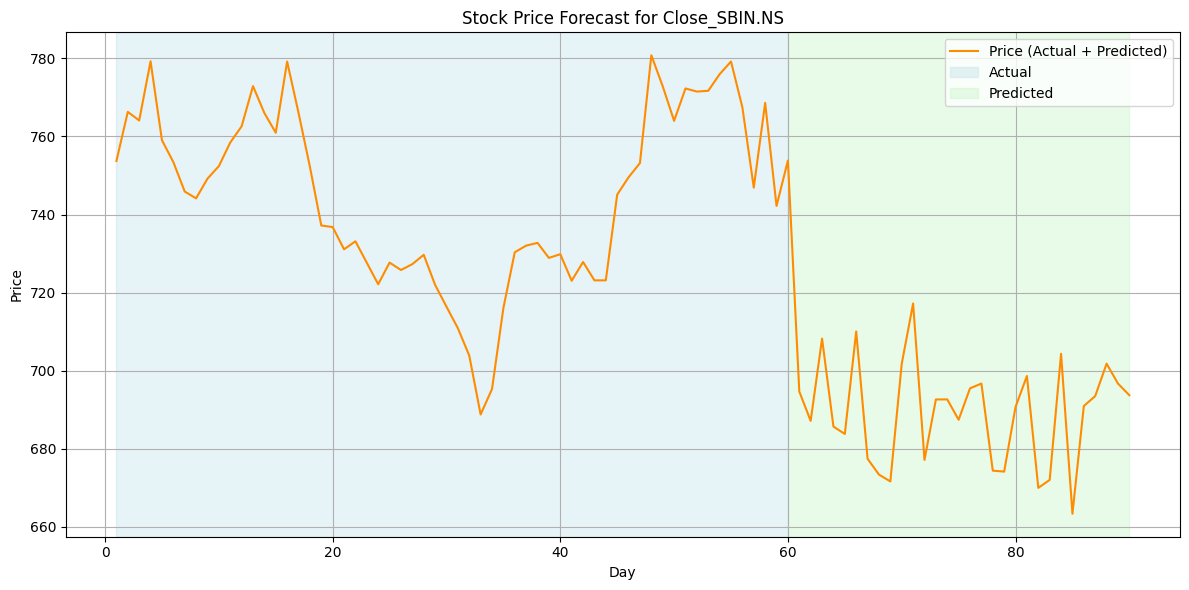

In [145]:
predicted_next_30 = predict_next_30_days(model, scaler, data)
plot_forecast(data, predicted_next_30,ticker)